In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import yaml
import torch
import torch.distributions as dist

import sys
sys.path.append("..")
from Source.plots import *
from Source.plot_utils import *

In [2]:
path_to_run = "/remote/gpu07/huetsch/JetCalibration/results/20250313_131855_EM2d_10files_50e_heteroscedastic_wayBigga"
path_to_predictions = os.path.join(path_to_run, "test_predictions.pt")
path_to_params = os.path.join(path_to_run, "params.yaml")

predictions = torch.load(path_to_predictions, weights_only=False)
params = yaml.load(open(path_to_params, 'r'), Loader=yaml.FullLoader)

data_folder = params["data_params"]["data_folder"]
n_files_test = params["data_params"].get("n_files_test", 1)

files = os.listdir(data_folder)
files = [file for file in files if file.endswith(".npy") and "full_data" not in file]
files.sort(key=lambda x: int(x.split("_")[-1].split(".")[0]))
data_paths = [os.path.join(data_folder, file) for file in files]
test_files = data_paths[-n_files_test:]

print(test_files)

targets_test = []
inputs_test = []
for i in range(n_files_test):
    data_i = np.load(test_files[i])

    nan_mask = np.isnan(data_i).any(axis=1)
    inf_mask = np.isinf(data_i).any(axis=1)
    data_i = data_i[~nan_mask & ~inf_mask]

    targets_test.append(data_i[:, params["data_params"]["target_dims"]])
    inputs_test.append(data_i[:, 2:])

targets_test = np.concatenate(targets_test, axis=0)
inputs_test = np.concatenate(inputs_test, axis=0)

targets_test = torch.from_numpy(targets_test)
inputs_test = torch.from_numpy(inputs_test)



['/remote/gpu07/huetsch/JetCalibration/data_v2/Ak10Jet_82.npy']


In [3]:
def sample(mu_pred, sigma_pred, weights_pred, n_samples=1):

    batch_size, num_components = weights_pred.shape  # Shape (batch, num_components)

    # Step 1: Expand inputs to allow multiple samples
    mu_pred = mu_pred.unsqueeze(1).expand(batch_size, n_samples, num_components)  # (batch, n_samples, num_components)
    sigma_pred = sigma_pred.unsqueeze(1).expand(batch_size, n_samples, num_components)  
    weights_pred = weights_pred.unsqueeze(1).expand(batch_size, n_samples, num_components)

    # Step 2: Sample `n_samples` component indices per batch element
    categorical_dist = dist.Categorical(weights_pred)  # Batch-wise categorical distribution
    gaussian_choices = categorical_dist.sample()  # (batch, n_samples)

    # Gather selected means and variances based on sampled component indices
    selected_means = torch.gather(mu_pred, 2, gaussian_choices.unsqueeze(-1)).squeeze(-1)  # (batch, n_samples)
    selected_sigmas = torch.gather(sigma_pred, 2, gaussian_choices.unsqueeze(-1)).squeeze(-1)  # (batch, n_samples)

    # Step 3: Sample from the selected Gaussian distributions
    normal_dist = dist.Normal(selected_means, selected_sigmas)  
    samples = normal_dist.sample()  # (batch, n_samples)

    # Step 4: Compute Log Likelihoods
    log_categorical_probs = categorical_dist.log_prob(gaussian_choices)  # (batch, n_samples)
    log_gaussian_likelihoods = normal_dist.log_prob(samples)  # (batch, n_samples)
    log_likelihoods = log_categorical_probs + log_gaussian_likelihoods  # (batch, n_samples)

    return samples, log_likelihoods

In [4]:
def sample(mu_pred, sigma_pred, n_samples=1):
    batch_size = mu_pred.shape[0]

    mu_pred = mu_pred.unsqueeze(1).expand(batch_size, n_samples)
    sigma_pred = sigma_pred.unsqueeze(1).expand(batch_size, n_samples)  

    normal_dist = dist.Normal(mu_pred, sigma_pred)  
    samples = normal_dist.sample()
    log_likelihoods = normal_dist.log_prob(samples)
    
    return samples, log_likelihoods

In [5]:
n_samples = 20

samples_E, log_likelihoods_E = sample(predictions["mu_E"], predictions["sigma_E"], n_samples=params.get("n_samples", 10))
samples_E = samples_E*predictions["preprocess_std"][0] + predictions["preprocess_mean"][0]
log_likelihoods_E = log_likelihoods_E/predictions["preprocess_std"][0]
samples_m, log_likelihoods_m = sample(predictions["mu_m"], predictions["sigma_m"], n_samples=params.get("n_samples", 10))
samples_m = samples_m*predictions["preprocess_std"][1] + predictions["preprocess_mean"][1]
log_likelihoods_m = log_likelihoods_m/predictions["preprocess_std"][1]
samples = torch.stack([samples_E, samples_m], dim=1)
log_likelihoods = torch.stack([log_likelihoods_E, log_likelihoods_m], dim=1)

In [10]:
def make_hist_1dim_ratio(truedata, meandata, modeldata, labels, colors, showratios, ratioref, xlabel, rlabel, xrange, ticks=[[], []], logscales=[False, True],
                         nbins=100, integrals=[], legend=['upper right', 0.95, 0.95, None], atlas_info=[0.97, 0.03, 'three-lines', 'right', 'bottom', 'none'], switch_legend=False):

    if logscales[0]: 
        bins = np.logspace(np.log10(xrange[0]), np.log10(xrange[1]), nbins+1)
    else:            
        bins = np.linspace(         xrange[0],           xrange[1],  nbins+1)

    hists_model = np.array([np.histogram(model, bins=bins)[0] for model in modeldata.T])
    hist_model_mean = np.mean(hists_model, axis=0)
    hist_model_std = np.std(hists_model, axis=0)

    hist_true = np.histogram(truedata, bins=bins)[0]
    hist_true_err = np.sqrt(hist_true)

    hist_mean = np.histogram(meandata, bins=bins)[0]
    hist_std = np.sqrt(hist_mean)
    
    hists = [hist_true, hist_mean, hist_model_mean]
    hists_err = [hist_true_err, hist_std, hist_model_std]
    if len(integrals) == 0: 
        integrals =  [np.sum(y_avg) for y_avg in hists]
    scales    = [1/integral if integral != 0.0 else 1.0 for integral in integrals]

    fig, axs = plt.subplots(2, 1, figsize=figs_ratio, sharex=True, gridspec_kw={'height_ratios': [3,1]})
    fig.tight_layout(pad=0.0, w_pad=0.0, h_pad=0.0, rect=rect_ratio); fig.subplots_adjust(hspace=0.07)
    atlas = atlas_info1 if atlas_info[2] == 'three-lines' else atlas_info2
    #axs[0].text(atlas_info[0], atlas_info[1], atlas, ha=atlas_info[3], va=atlas_info[4], transform=axs[0].transAxes, bbox=dict(boxstyle='round', fc=atlas_info[5], ec='none', alpha=0.75))

    steps = []; fills = []
    for i, y_avg, y_err, scale, color, label in zip(range(len(hists)), hists, hists_err, scales, colors, labels):

        step = axs[0].step(bins, scale*dup_last(y_avg), alpha=1.00, linewidth=1.00, where='post', color=color, label=label)
        axs[0].step(bins, scale*dup_last(y_avg-y_err),  alpha=0.50, linewidth=0.50, where='post', color=color)
        axs[0].step(bins, scale*dup_last(y_avg+y_err),  alpha=0.50, linewidth=0.50, where='post', color=color)
        fill = axs[0].fill_between(bins, scale*dup_last(y_avg-y_err), scale*dup_last(y_avg+y_err), alpha=0.20, step='post', facecolor=color)
        steps.append(step[0]); fills.append(fill)

        if showratios[i]:
            
            with np.errstate(all='ignore'):
                ratio_avg = get_ratio(scale*y_avg, scales[ratioref]*hists[ratioref])
                ratio_err = np.sqrt(get_ratio(y_err, y_avg)**2+get_ratio(hists_err[ratioref], hists[ratioref])**2)
            #ratio_nan = np.isnan(ratio_avg)
            #ratio_avg[ratio_nan] = 1.0
            #ratio_err[ratio_nan] = 0.0

            axs[1].step(bins, dup_last(ratio_avg),           alpha=1.00, linewidth=1.00, where='post', color=color)
            axs[1].step(bins, dup_last(ratio_avg-ratio_err), alpha=0.50, linewidth=0.50, where='post', color=color)
            axs[1].step(bins, dup_last(ratio_avg+ratio_err), alpha=0.50, linewidth=0.50, where='post', color=color)
            axs[1].fill_between(bins, dup_last(ratio_avg-ratio_err), dup_last(ratio_avg+ratio_err), alpha=0.20, step='post', facecolor=color)

    if switch_legend:
        _, labels = axs[0].get_legend_handles_labels()
        handles = [(step, fill) for step, fill in zip(steps[::-1], fills[::-1])]
        axs[0].legend(handles, labels[::-1], alignment='left', title=legend[3], loc=legend[0], bbox_to_anchor=(legend[1], legend[2]))
    else:
        _, labels = axs[0].get_legend_handles_labels()
        handles = [(step, fill) for step, fill in zip(steps, fills)]
        axs[0].legend(handles, labels, alignment='left', title=legend[3], loc=legend[0], bbox_to_anchor=(legend[1], legend[2]))

    axs[1].axhline(1.50, zorder=0, linestyle='dotted', color='grey')
    axs[1].axhline(1.00, zorder=0, linestyle='dashed', color='black')
    axs[1].axhline(0.50, zorder=0, linestyle='dotted', color='grey')
    axs[1].set_xlabel(xlabel)
    axs[0].set_ylabel('Relative entries')
    axs[1].set_ylabel(rlabel, loc='center')
    axs[0].set_xlim((bins[0], bins[-1]))
    axs[1].set_ylim((0, 2))
    axs[1].set_yticks([0, 0.5, 1, 1.5, 2])
    if logscales[0]:
        axs[0].set_xscale('log')
        axs[0].xaxis.set_minor_locator(mpl.ticker.LogLocator(base=10.0, subs=subs, numticks=999))
        axs[0].xaxis.set_minor_formatter(mpl.ticker.NullFormatter())
    if logscales[1]:
        axs[0].set_yscale('log')
        axs[0].yaxis.set_minor_locator(mpl.ticker.LogLocator(base=10.0, subs=subs, numticks=999))
        axs[0].yaxis.set_minor_formatter(mpl.ticker.NullFormatter())
    if len(ticks[0]) > 0: axs[1].set_xticks(ticks[0])
    if len(ticks[1]) > 0: axs[0].set_yticks(ticks[1])

    return fig, axs


c_bk = '#0a0a0a' # black      RGB(10,  10,  10)
c_rd = '#ff0000' # red        RGB(255, 0, 0)
c_gn = '#00CC00' # green      RGB(0, 204, 0)
#c_gn = '#3BC14A' # green      RGB(0, 204, 0)
c_bl = '#0000ff' # blue       RGB(0, 0, 255)
c_yl = '#ffff00' # yellow     RGB(255, 255, 0)
c_cy = '#00ffff' # cyan       RGB(0, 255, 255)
c_db = '#006699' # dark blue  RGB( 0, 102, 153)
c_br = '#663300' # brown      RGB(102, 51, 0)
colors = {'bk': c_bk, 'rd': c_rd, 'gn': c_gn, 'bl': c_bl, 'yl': c_yl, 'cy': c_cy, 'db': c_db, 'br': c_br}

In [7]:
r_truth = 10**targets_test.squeeze().numpy()
r_pred = 10**samples.squeeze().numpy()
r_pred_mean = 10**samples.mean(axis=-1).squeeze().numpy()


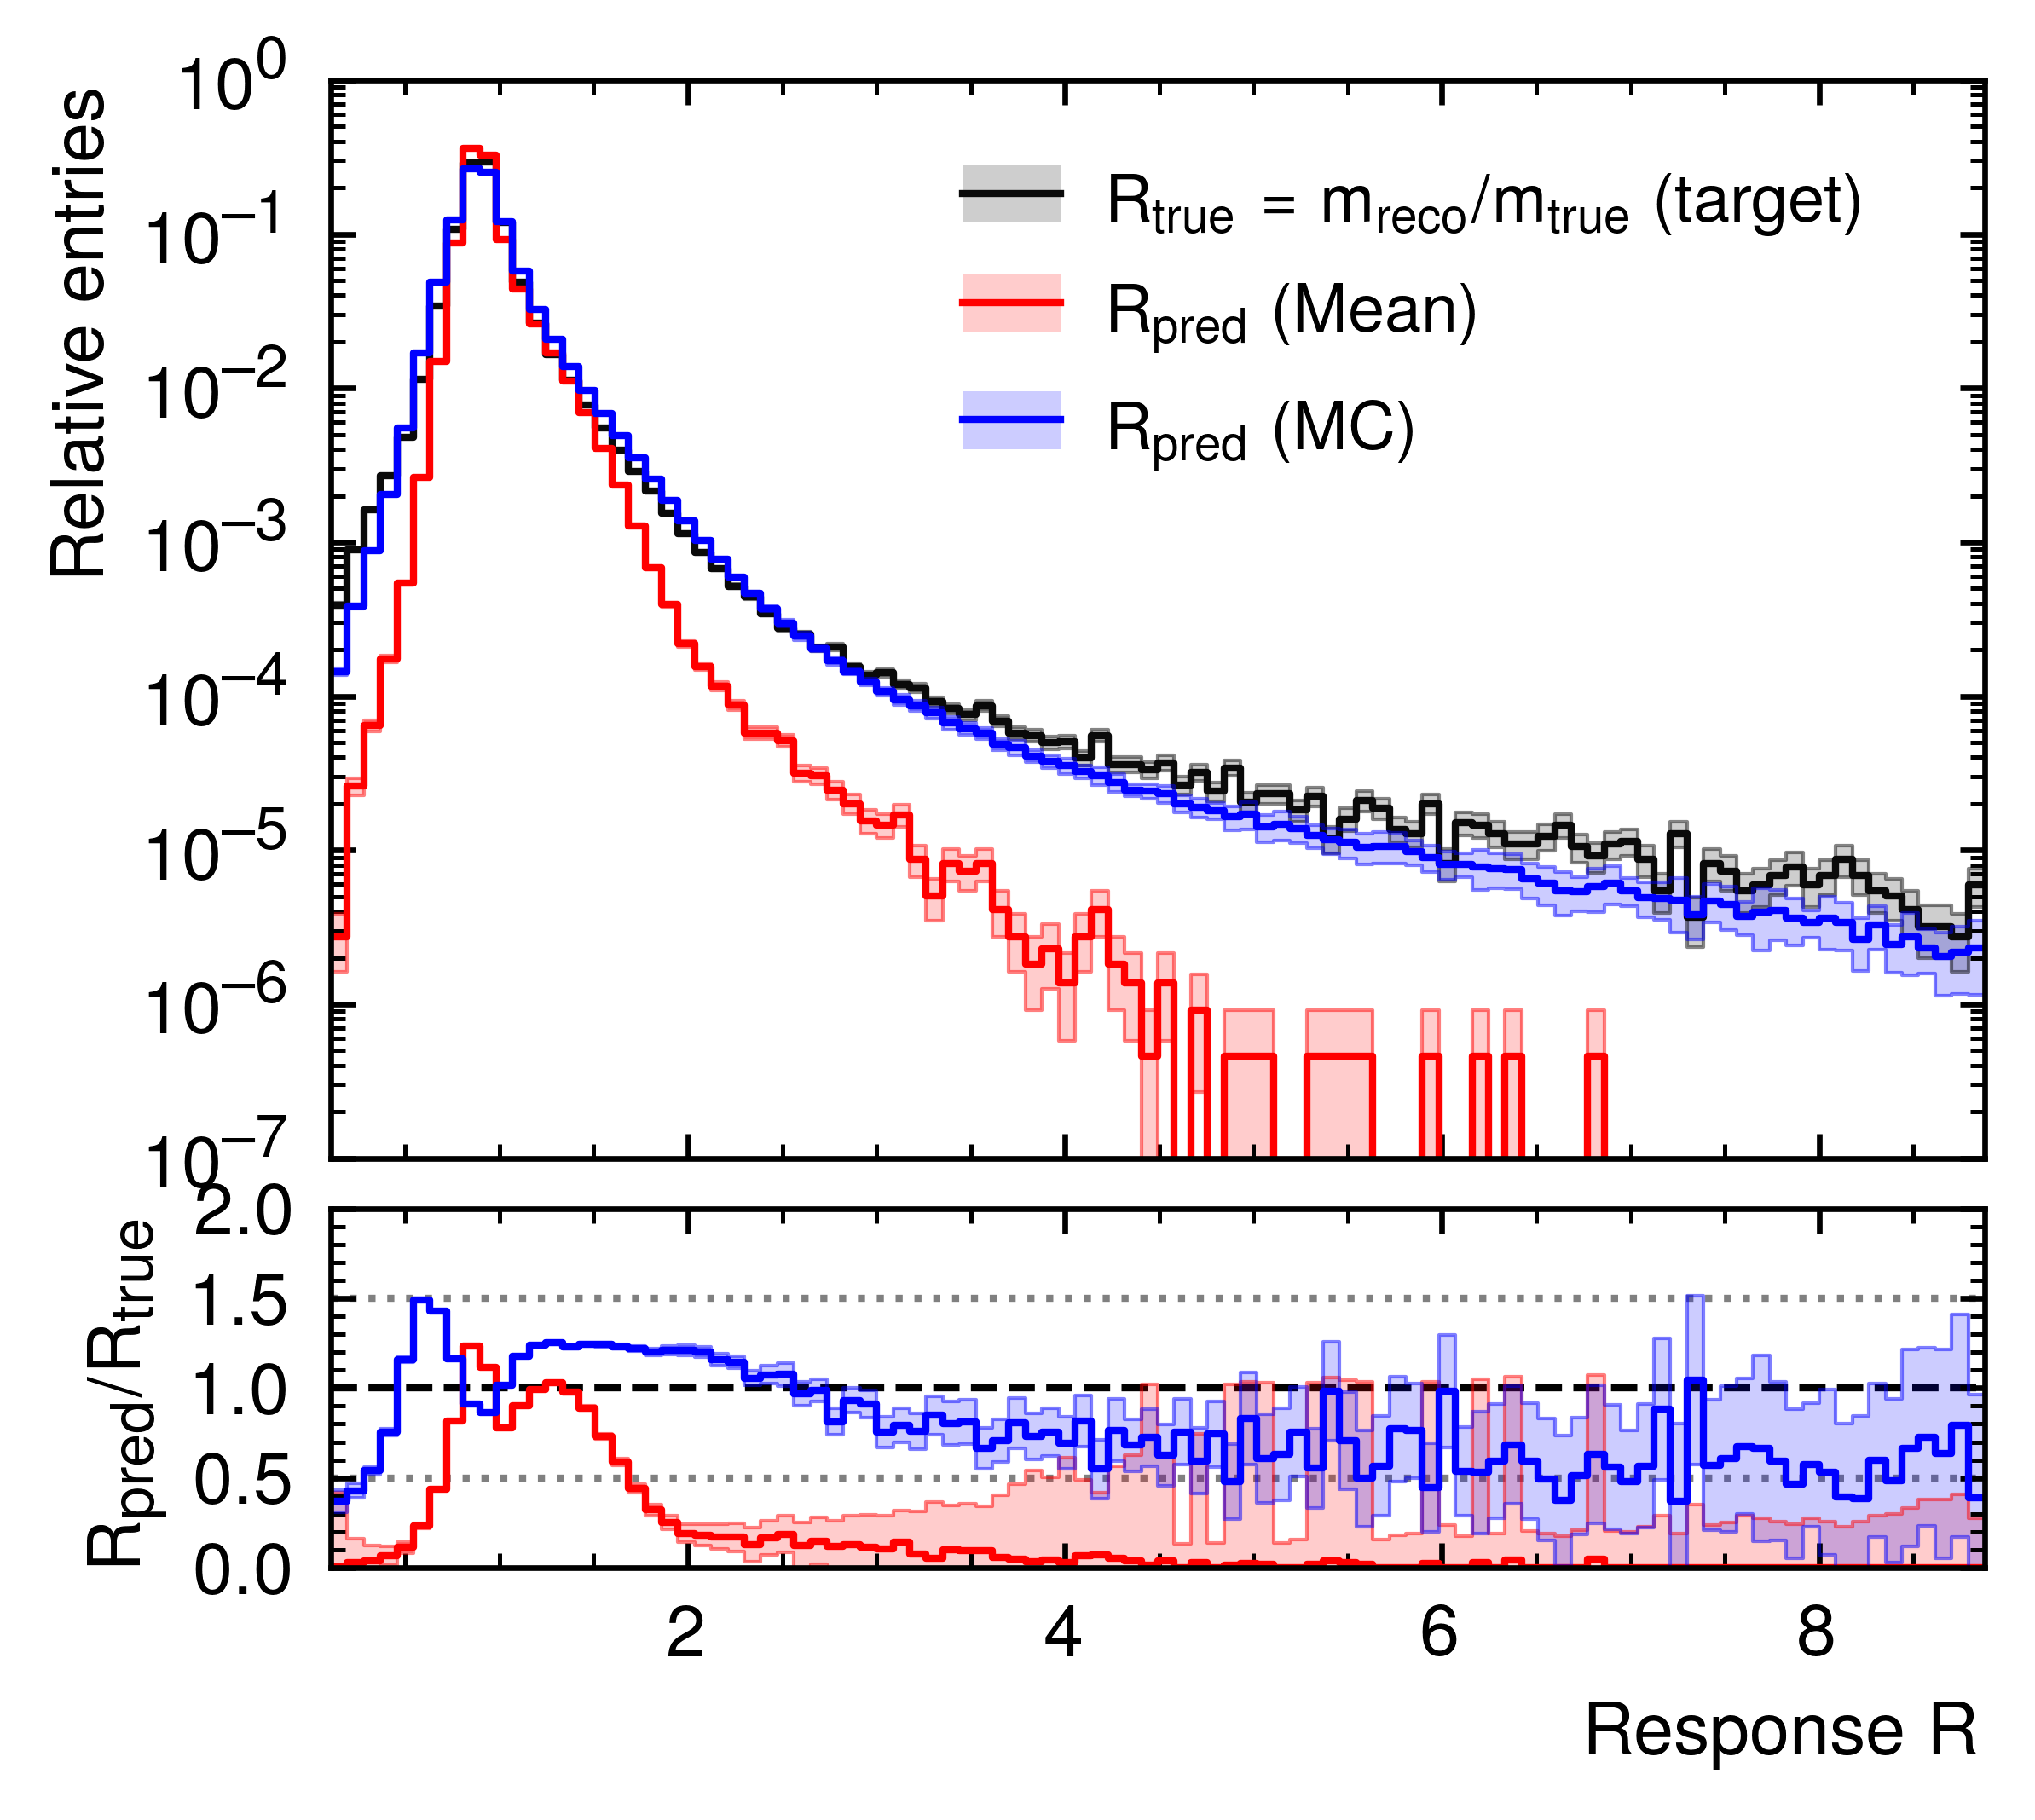

In [13]:
r_range = compute_range([r_truth[:, 1], r_pred[:, 1, 0]])
fig, axs =  make_hist_1dim_ratio(
    truedata   = r_truth[:, 1],
    meandata   = r_pred_mean[:, 1],
    modeldata  = r_pred[:, 1],
    labels     = ['$R_{\\text{true}}=m_{\\text{reco}}/m_{\\text{true}}$ (target)', '$R_{\\text{pred}}$ (Mean)', 
                '$R_{\\text{pred}}$ (MC)'],
    colors     = [colors['bk'], colors["rd"], colors['bl']],
    showratios = [False, True, True],
    ratioref   = 0,
    xlabel     = 'Response $R$',
    rlabel     = '$R_{\\text{pred}}/R_{\\text{true}}$',
    xrange     = r_range,
    ticks      = [[], [1e0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7]],
    logscales  = [False, True],
    nbins      = 100,
    legend     = ['upper right', 0.95, 0.95, None],
    atlas_info = [0.04, 0.95, 'four-lines', 'left', 'top', 'none'])
fig.savefig(os.path.join(path_to_run, "rhist_m.pdf"), format='pdf')
fig.show()
#plt.close(fig)

In [19]:
r_pred.mean()

0.94627917

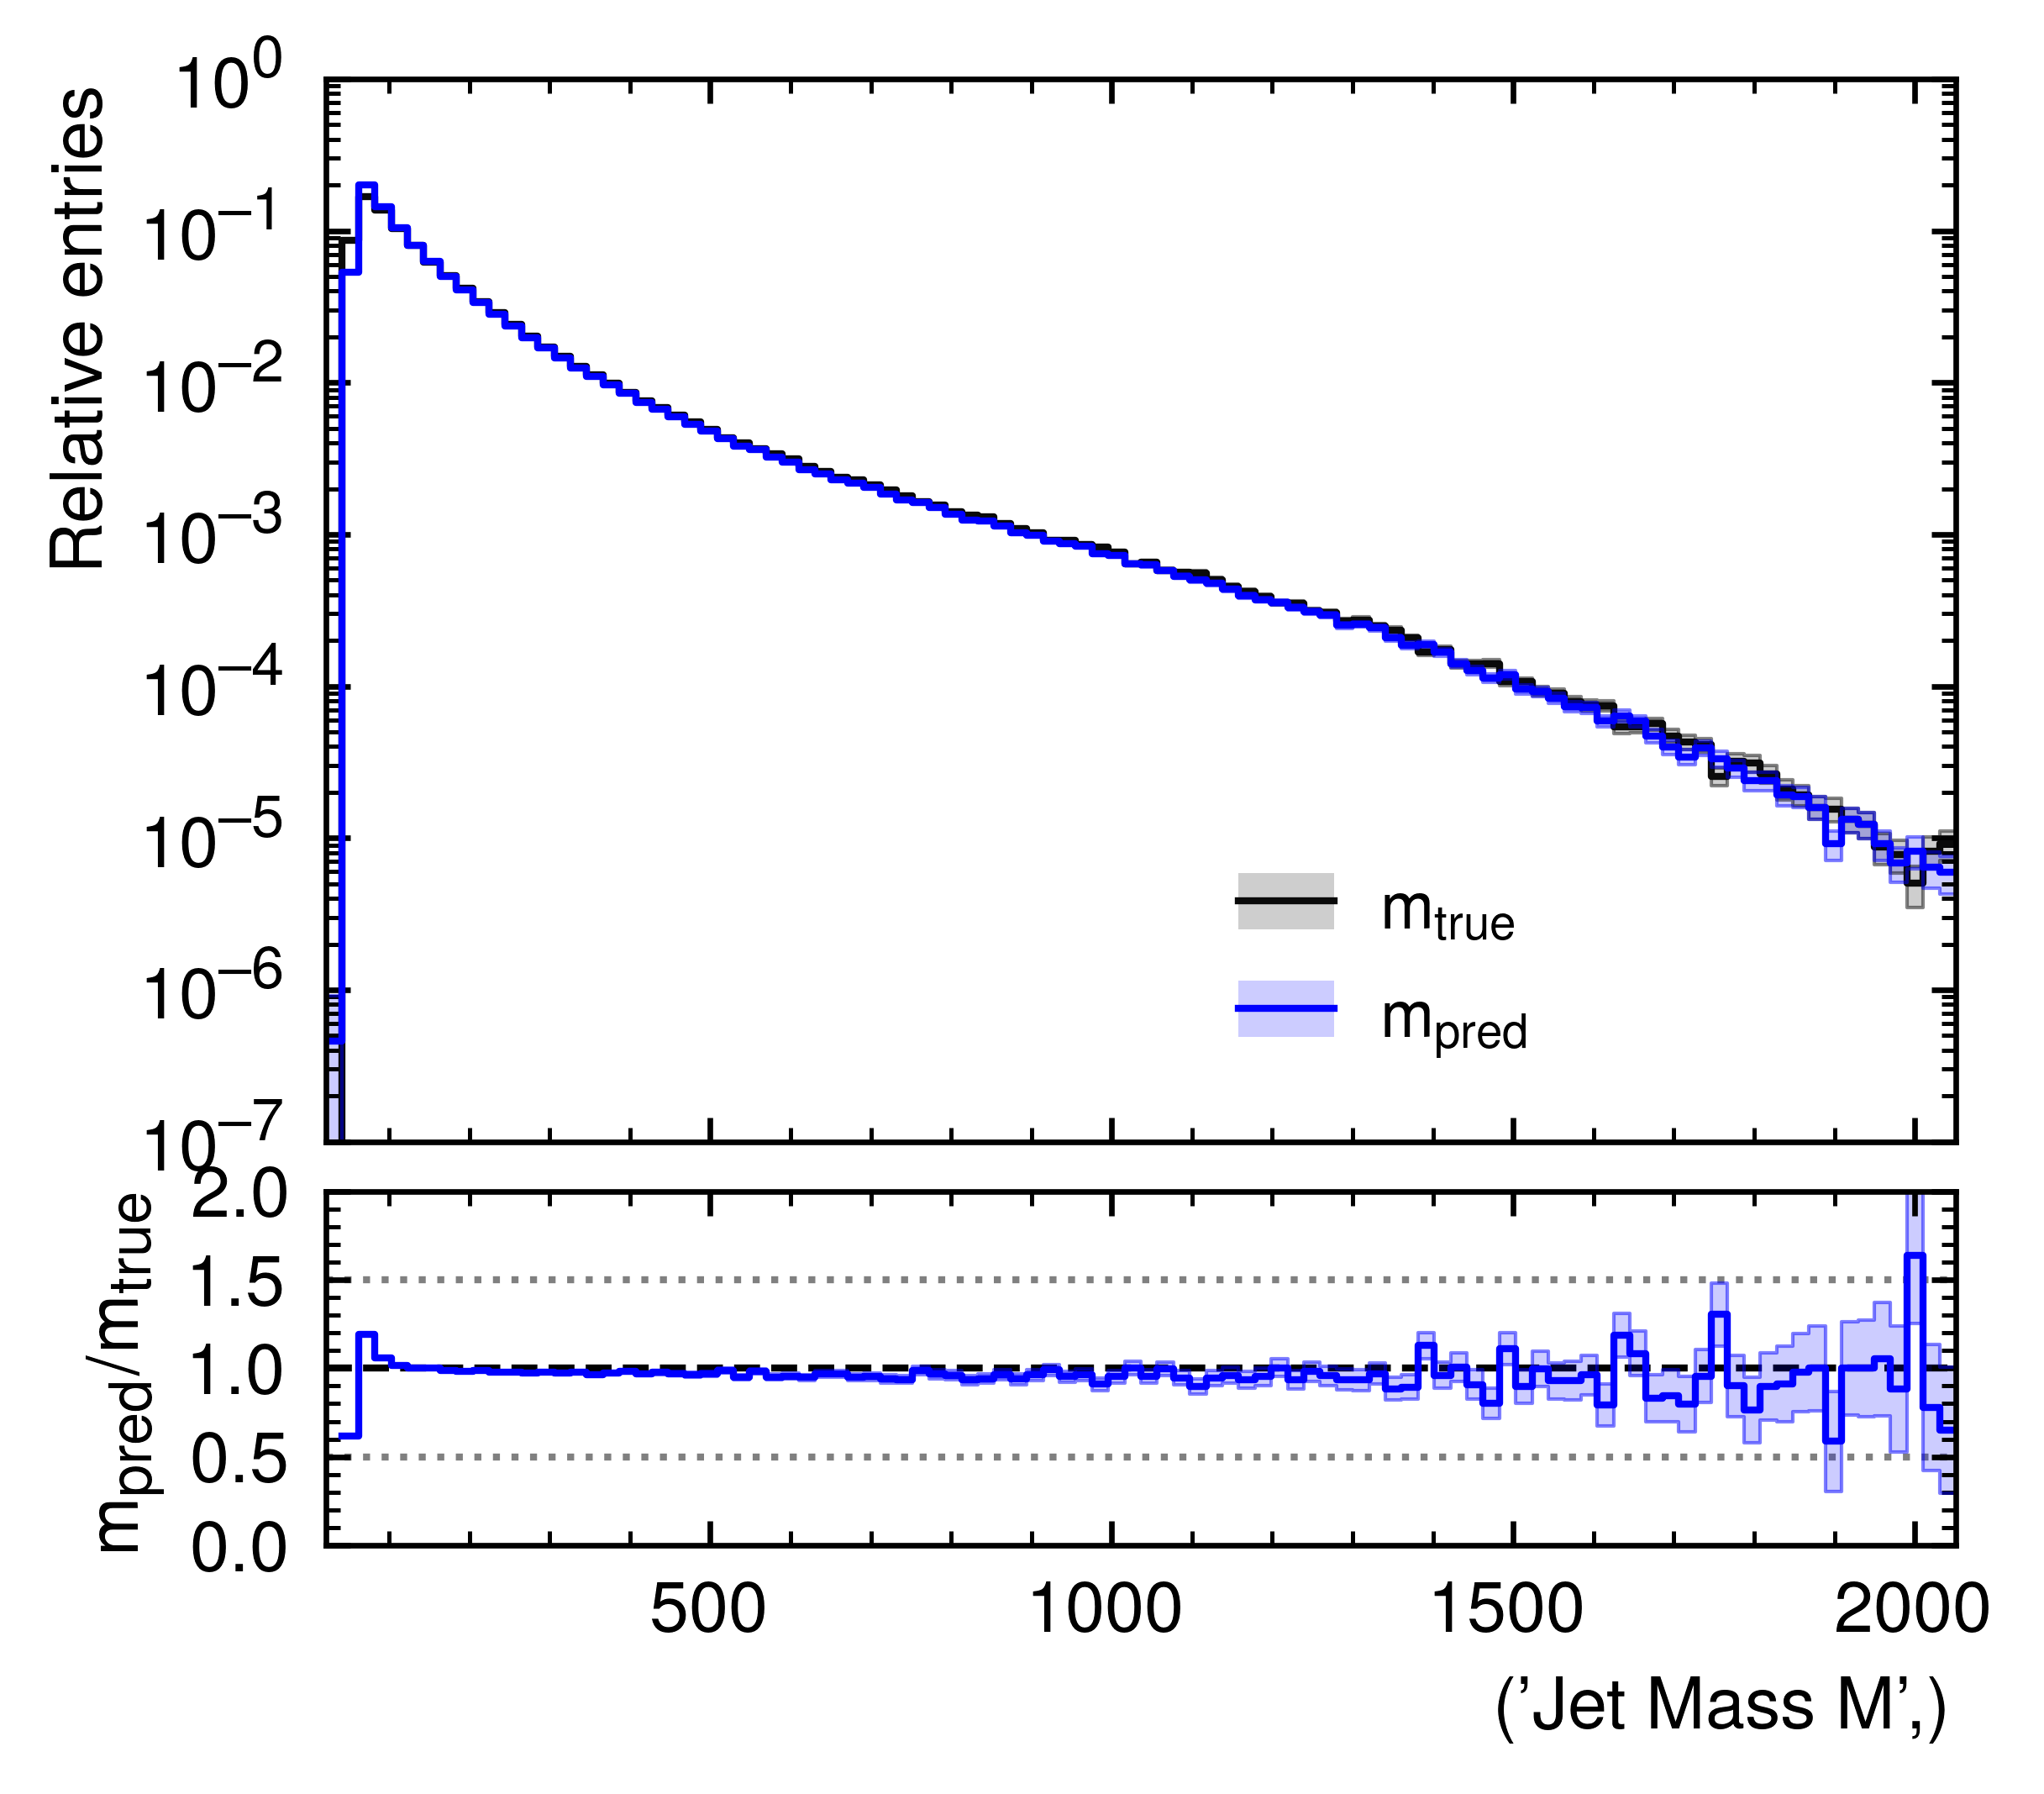

In [15]:
r_truth = 10**targets_test.squeeze().numpy()[:, 1]
r_pred = 10**samples.squeeze().numpy()[:, 1]
r_pred_mean = 10**samples.mean(axis=-1).squeeze().numpy()[:, 1]
variable = "m"

if variable == "E":
    truth = (1./r_truth) * inputs_test[:, 0].numpy()
    ins = inputs_test[:, 0].numpy()
    pred = (1./r_pred) * ins[:, np.newaxis]

    pred_mean = (1./r_pred_mean) * ins

    E_range = compute_range([truth, pred[:, 0]])
    labels = ['$E_{\\text{true}}$', '$E_{\\text{pred}}$ Mean',
                '$E_{\\text{pred}}$ MC']
    xlabel = 'Jet Energy $E$',
    rlabel = '$E_{\\text{pred}}/E_{\\text{true}}$'
else:
    truth = (1./r_truth) * inputs_test[:, 1].numpy()
    ins = inputs_test[:, 1].numpy()
    pred = (1./r_pred) * ins[:, np.newaxis]

    pred_mean = (1./r_pred_mean) * ins

    m_range = compute_range([truth, pred[:, 0]])

    labels = ['$m_{\\text{true}}$',
                '$m_{\\text{pred}}$']
    xlabel = 'Jet Mass $M$',
    rlabel = '$m_{\\text{pred}}/m_{\\text{true}}$'


fig, axs =  make_hist_1dim_ratio(
    truedata   = truth,
    meandata   = pred_mean,
    modeldata  = pred,
    labels     = labels,
    colors     = [colors['bk'], colors['bl'], colors['rd']],
    showratios = [False, True, True],
    ratioref   = 0,
    xlabel     = xlabel,
    rlabel     = rlabel,
    xrange     = m_range,
    ticks      = [[], [1e0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7]],
    logscales  = [False, True],
    nbins      = 100,
    legend     = ['lower center', 0.65, 0.05, None],
    atlas_info = [0.04, 0.95, 'four-lines', 'left', 'top', 'none'])

fig.savefig(os.path.join(path_to_run, "Ehist.pdf"), format='pdf')
fig.show()

In [20]:
n_samples = 2

samples_E, log_likelihoods_E = sample(predictions["mu_E"], predictions["sigma_E"], predictions["weights_E"], n_samples=n_samples)
samples_E = samples_E*predictions["preprocess_std"][0] + predictions["preprocess_mean"][0]
log_likelihoods_E = log_likelihoods_E/predictions["preprocess_std"][0]
samples_m, log_likelihoods_m = sample(predictions["mu_m"], predictions["sigma_m"], predictions["weights_m"], n_samples=n_samples)
samples_m = samples_m*predictions["preprocess_std"][1] + predictions["preprocess_mean"][1]
log_likelihoods_m = log_likelihoods_m/predictions["preprocess_std"][1]
samples = torch.stack([samples_E, samples_m], dim=1)
log_likelihoods = torch.stack([log_likelihoods_E, log_likelihoods_m], dim=1)

In [21]:
for target_dim in params["data_params"]["target_dims"]:
    variable = ["E", "m"][target_dim]
    os.makedirs(os.path.join(path_to_run, f"plots_manual_{variable}"), exist_ok=True)
    plot_dir = os.path.join(path_to_run, f"plots_manual_{variable}")
    plotter = Plotter(plot_dir, 
                            params, 
                            {key: predictions[key] for key in predictions.keys() if variable in key}, 
                            inputs_test, 
                            targets_test[:, target_dim], 
                            samples[:, target_dim], 
                            log_likelihoods[:, target_dim])
    plotter.plot_inputs_histogram("inputs_histogram.pdf")
    plotter.r_predictions_histogram("r_predictions_histogram.pdf")
    plotter.r_2d_histogram("r_2d_histogram.pdf")
    plotter.E_M_predictions_histogram(f"{variable}_predictions_histogram.pdf", variable)
    plotter.pred_inputs_histogram("pred_inputs_histogram.pdf")
    #plotter.pred_inputs_histogram_marginalized("pred_inputs_histogram_marginalized.pdf")

    if params["model_params"]["model"] == "MLP_GMM_Regression":
        plotter.plot_GMM_weights("GMM_weights.pdf")

KeyboardInterrupt: 

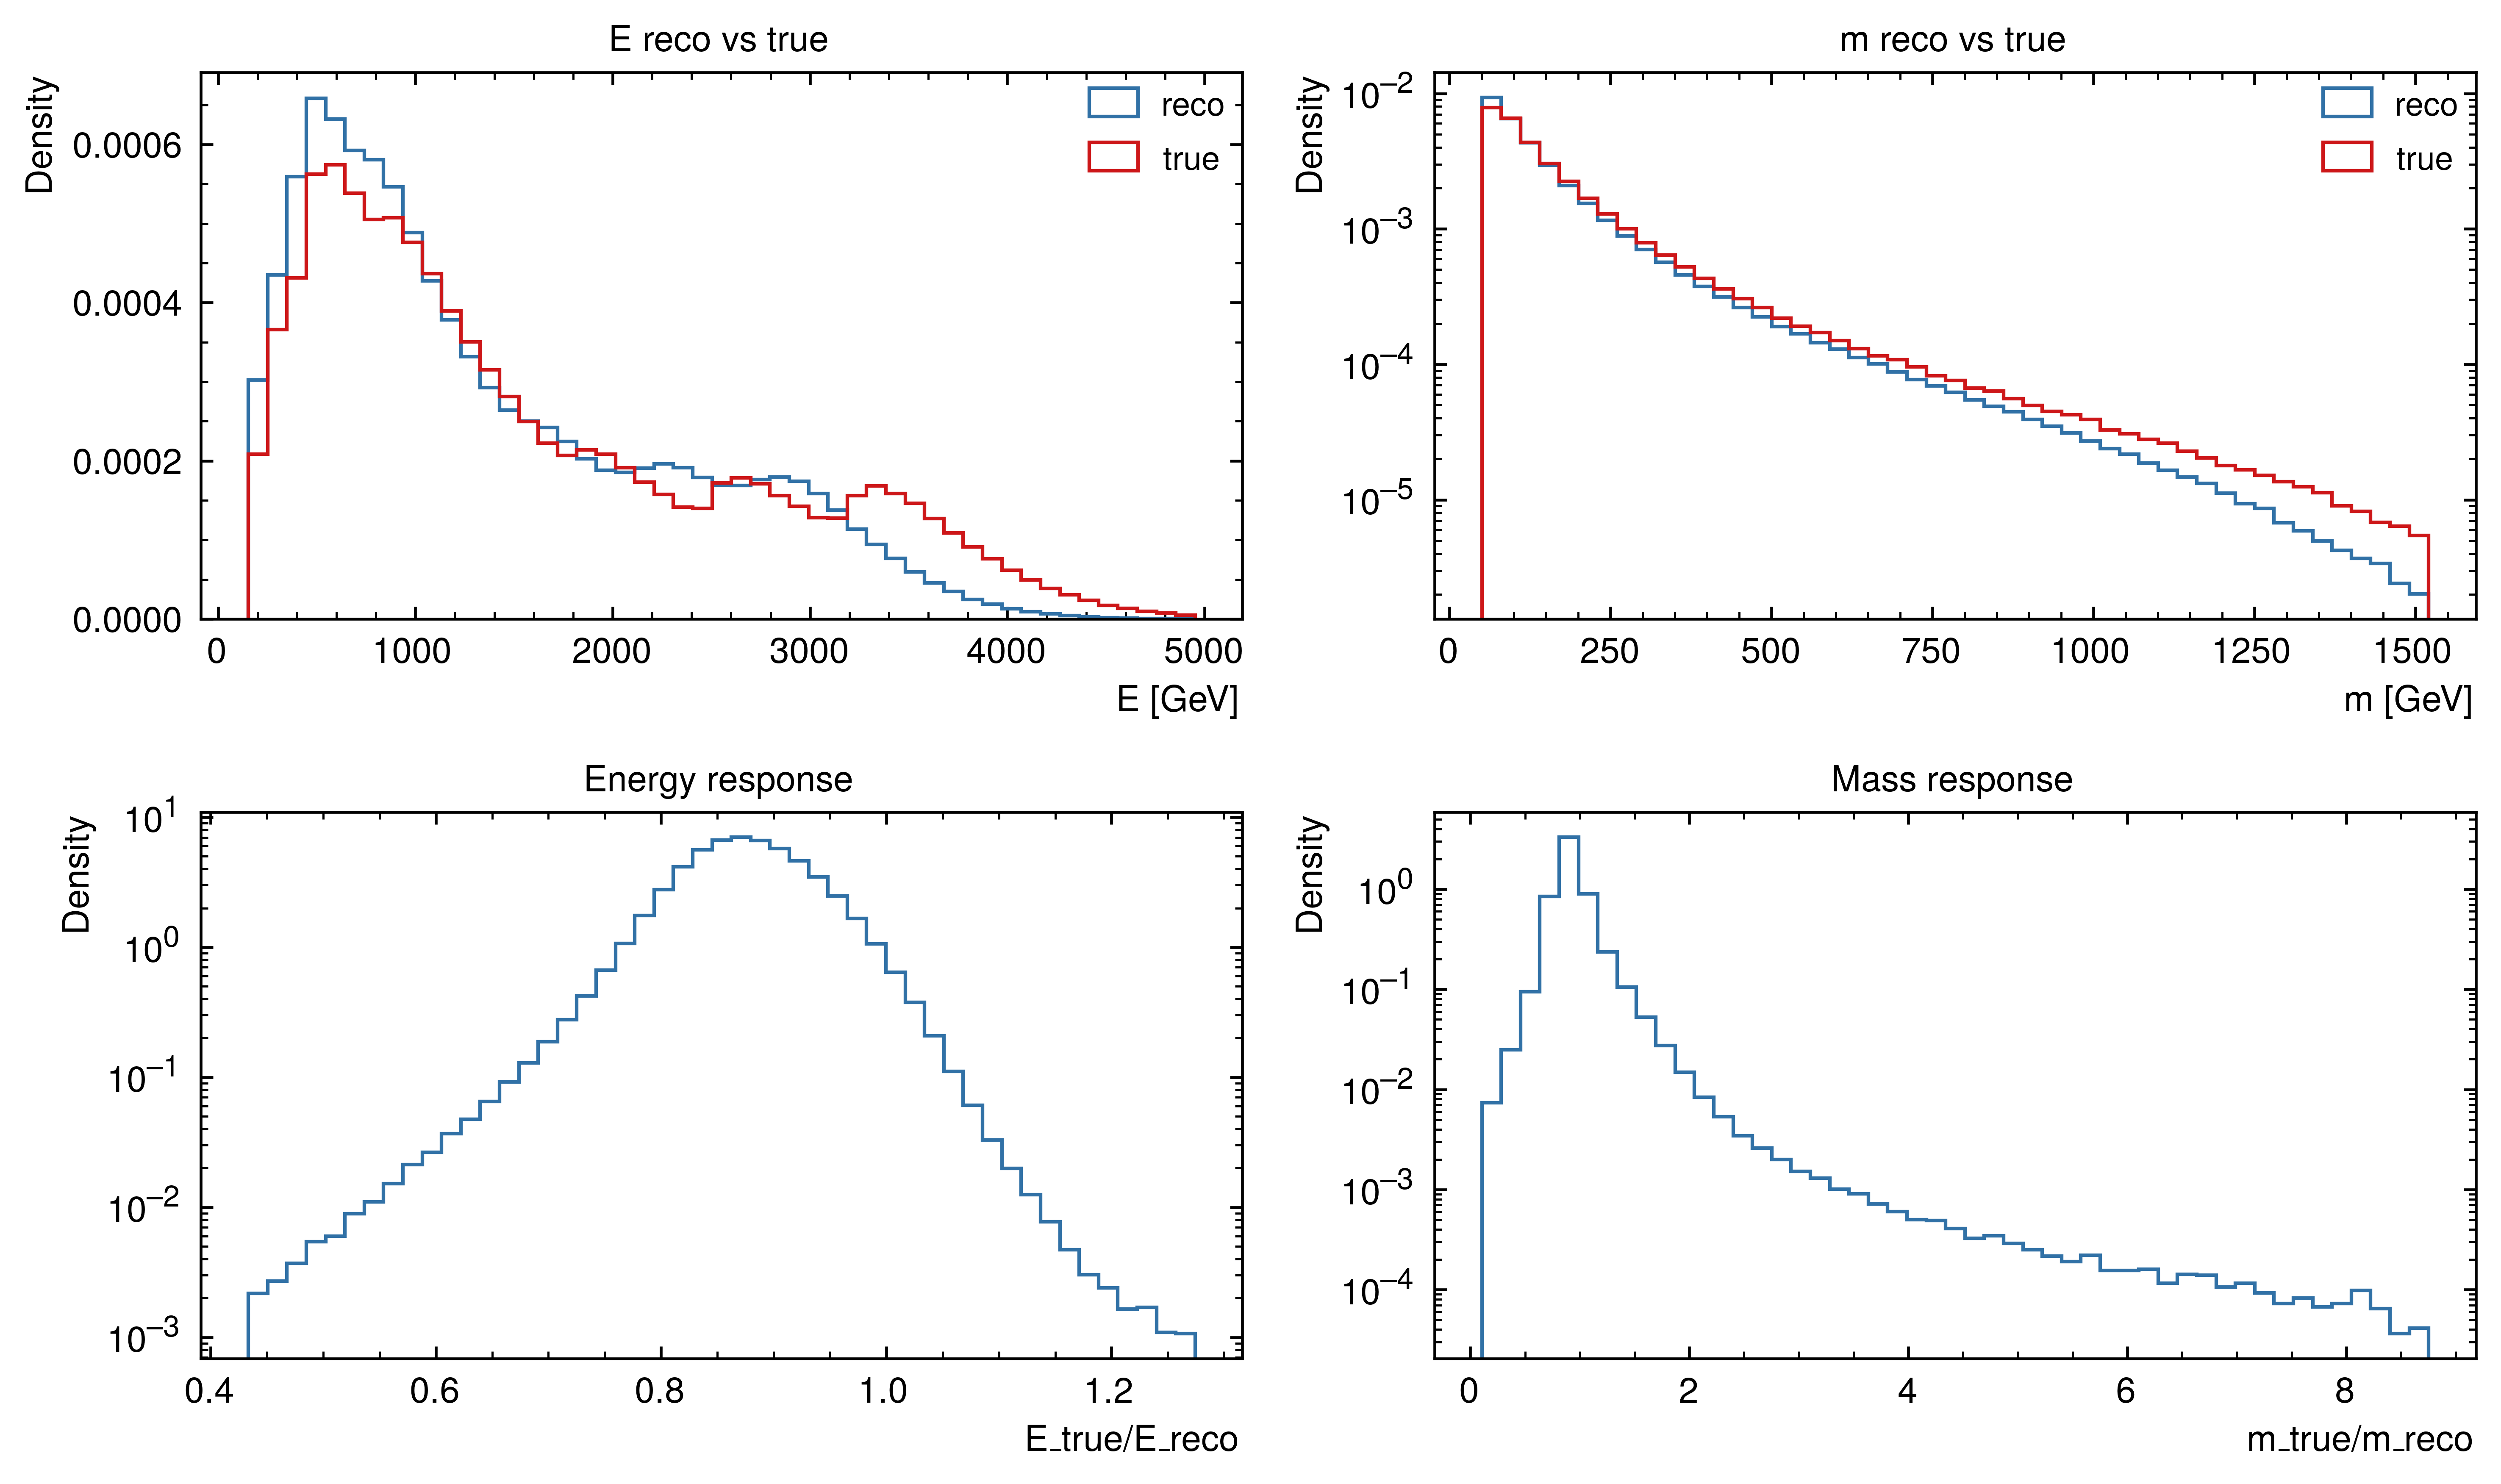

In [39]:
ratio_E = (10**targets_test[:, 0]).numpy()
ratio_m = (10**targets_test[:, 1]).numpy()

E_reco = inputs_test[:, 0].numpy()
m_reco = inputs_test[:, 1].numpy()
E_true = E_reco / ratio_E
m_true = m_reco / ratio_m


fig, axs = plt.subplots(2, 2, figsize=(10, 6))

bins_E = np.linspace(np.quantile(E_true, 0.001), np.quantile(E_true, 0.999), 50)
bins_m = np.linspace(np.quantile(m_true, 0.001), np.quantile(m_true, 0.999), 50)


axs[0, 0].hist(E_reco, bins=bins_E, histtype="step", label="reco", density=True)
axs[0, 0].hist(E_true, bins=bins_E, histtype="step", label="true", density=True)
axs[0, 0].legend()
axs[0, 0].set_xlabel("E [GeV]")
axs[0, 0].set_ylabel("Density")
axs[0, 0].set_title("E reco vs true")

axs[0, 1].hist(m_reco, bins=bins_m, histtype="step", label="reco", density=True)
axs[0, 1].hist(m_true, bins=bins_m, histtype="step", label="true", density=True)
axs[0, 1].legend()
axs[0, 1].set_xlabel("m [GeV]")
axs[0, 1].set_ylabel("Density")
axs[0, 1].set_title("m reco vs true")
axs[0, 1].set_yscale("log")

bins = np.linspace(np.quantile(ratio_E, 0.0001), np.quantile(ratio_E, 0.9999), 50)
axs[1, 0].hist(ratio_E, bins=bins, density=True, histtype="step")
axs[1, 0].set_xlabel("E_true/E_reco")
axs[1, 0].set_ylabel("Density")
axs[1, 0].set_title("Energy response")
axs[1, 0].set_yscale("log")


bins = np.linspace(np.quantile(ratio_m, 0.0001), np.quantile(ratio_m, 0.9999), 50)
axs[1, 1].hist(ratio_m, bins=bins, density=True, histtype="step")
axs[1, 1].set_xlabel("m_true/m_reco")
axs[1, 1].set_ylabel("Density")
axs[1, 1].set_title("Mass response")
axs[1, 1].set_yscale("log")
plt.tight_layout()
plt.savefig(os.path.join(path_to_run, "dataset.pdf"))
plt.show()

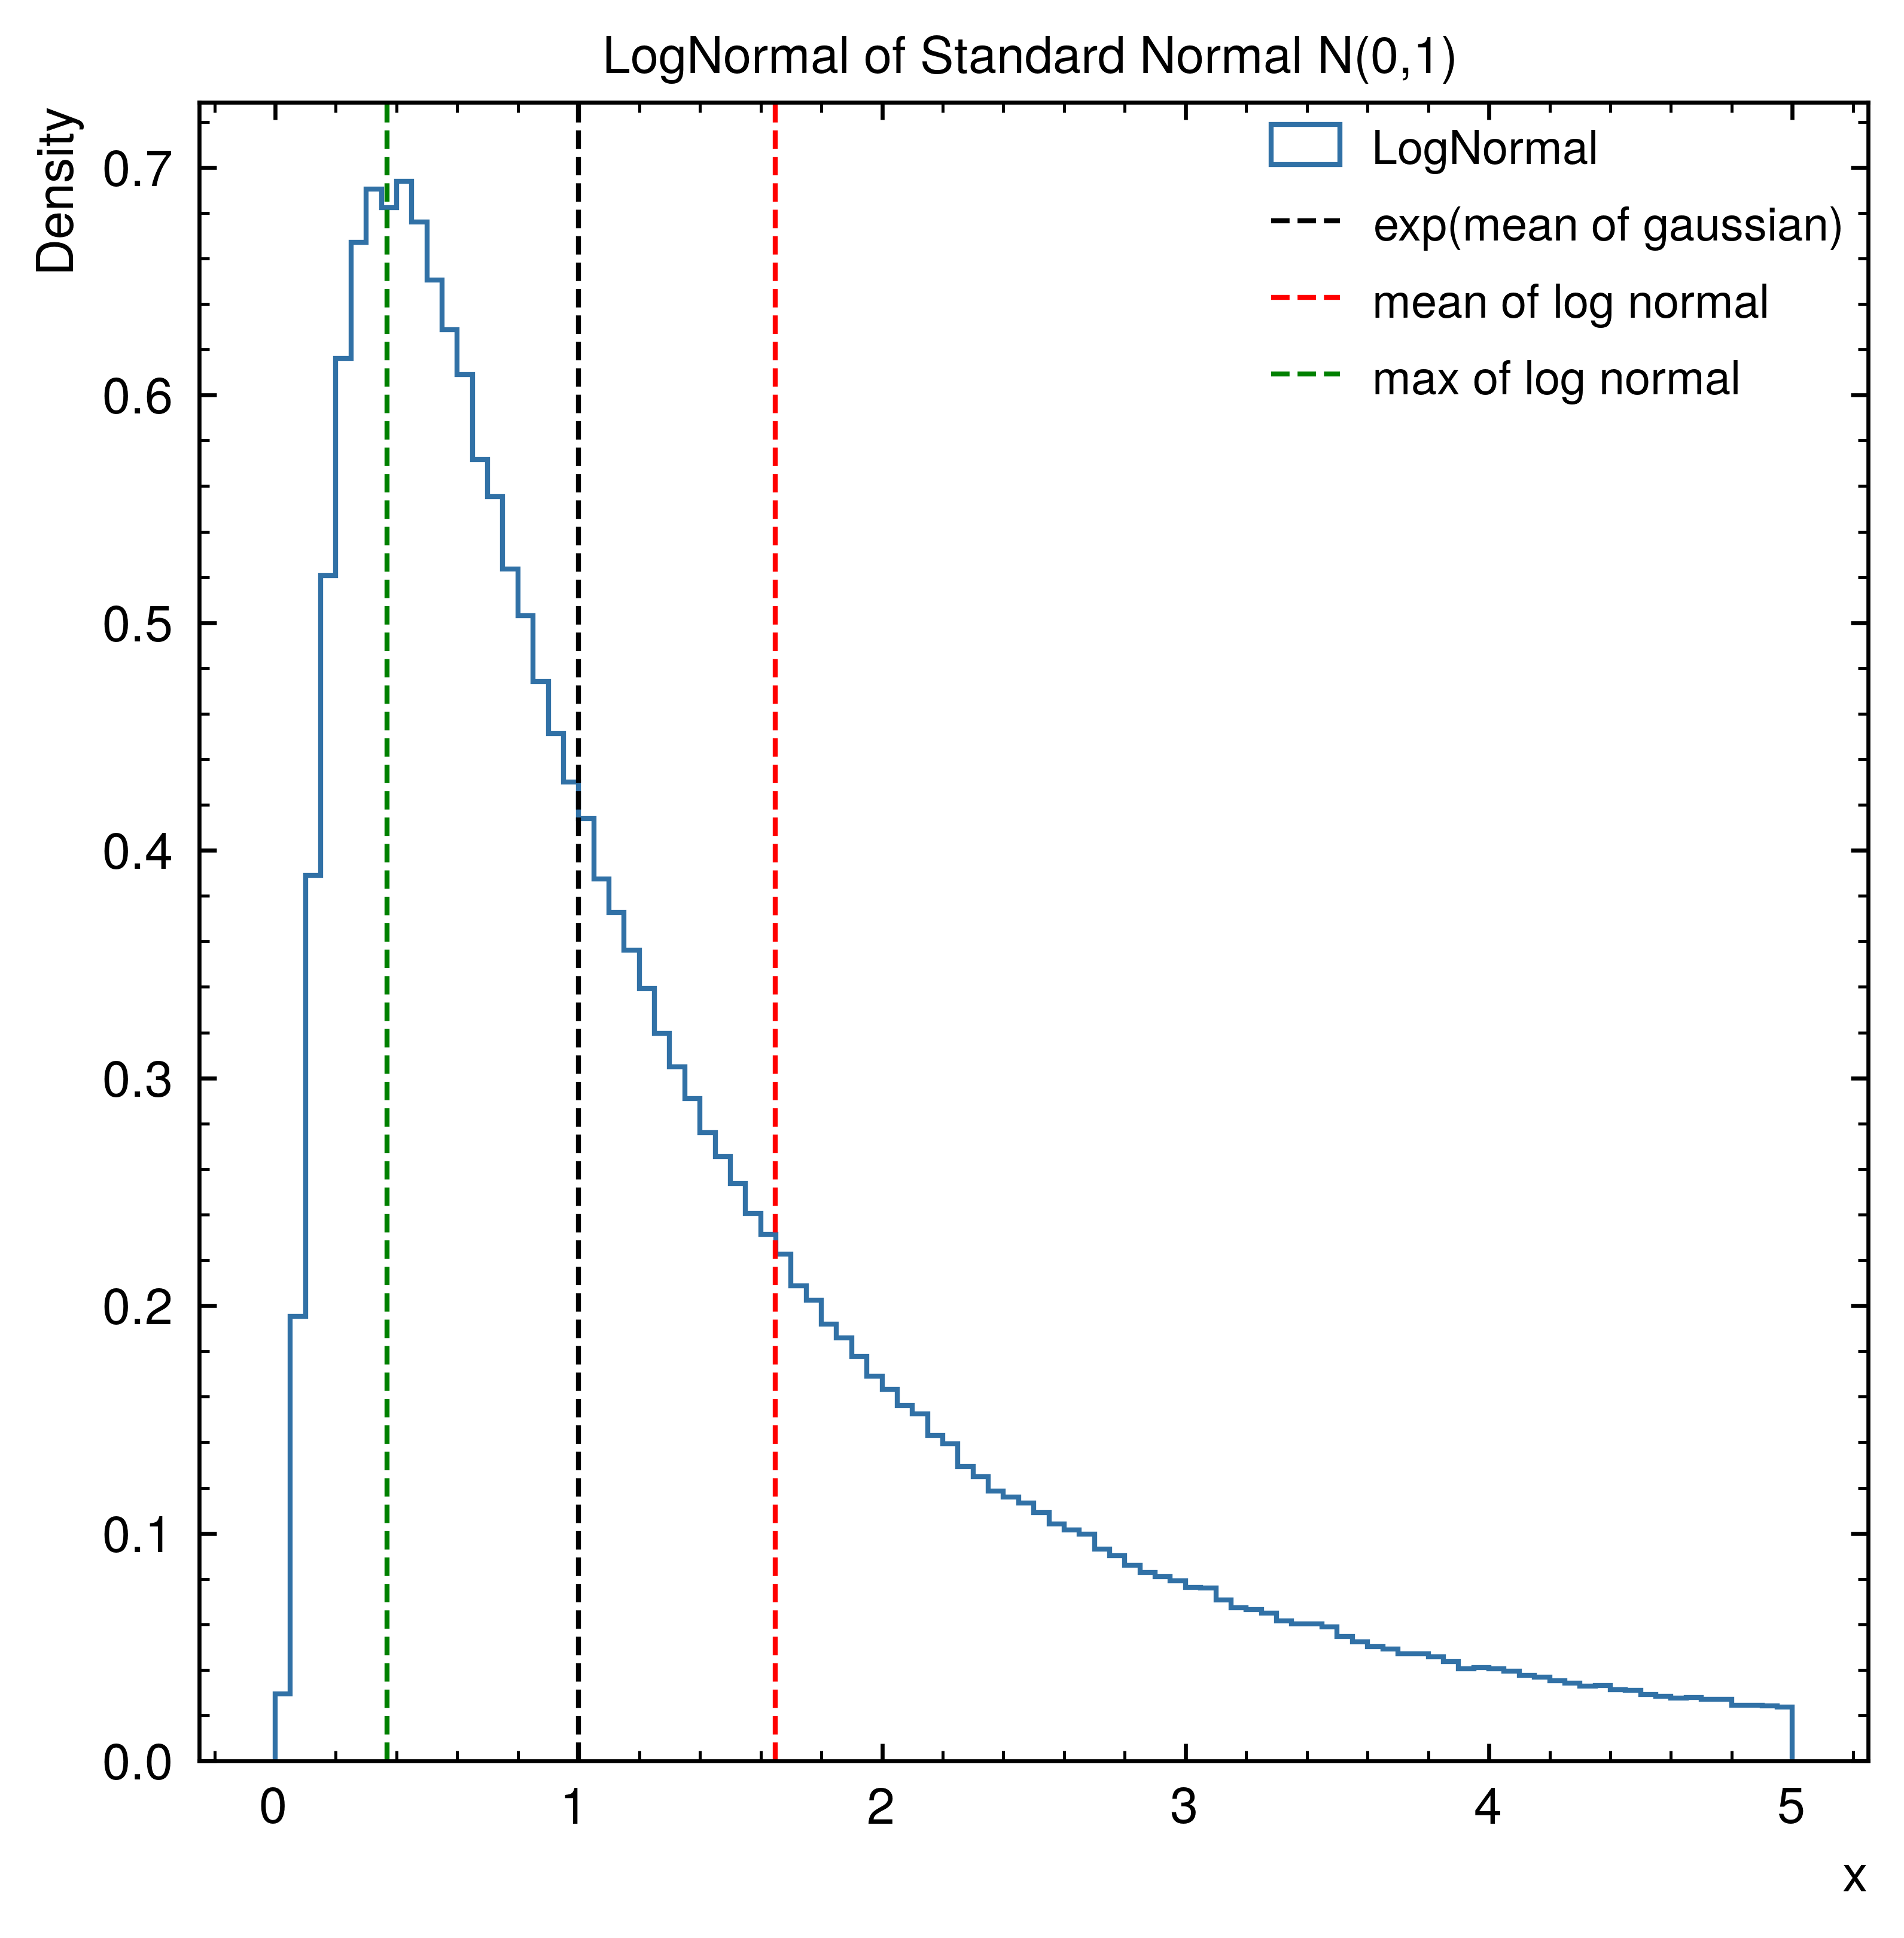

In [19]:
# 1m numpy random samples
normal_samples = np.random.normal(0, 1, 1000000)
log_normal_samples = np.exp(normal_samples)

plt.figure(figsize=(6, 6))
#plt.hist(normal_samples, bins=100, range=(-5, 10), density=True, histtype="step", label="normal")
plt.hist(log_normal_samples, bins=100, range=(0, 5), density=True, histtype="step", label="LogNormal")
# vertical line at x=1
plt.axvline(x=np.exp(0), color="black", linestyle="--", label="exp(mean of gaussian)")
# vertical line at the mean of the log normal
plt.axvline(x=np.exp(1/2), color="red", linestyle="--", label="mean of log normal")
# vertical line at the maximum of the log normal
plt.axvline(x=np.exp(-1), color="green", linestyle="--", label="max of log normal")
plt.legend()
plt.title("LogNormal of Standard Normal N(0,1)")
plt.xlabel("x")
plt.ylabel("Density")
plt.show()
